In [21]:
from datetime import datetime
from scipy.optimize import linprog
from scipy import optimize

import sys
sys.path.append(r'c:\users\severusbot\appdata\local\programs\python\python39\lib\site-packages')

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import os


## $\color{red}{\text{Get Data}}$

We will use python's Yahoo Finance package to get historical stock data. Following the paper's methods,
we will look at daily return data from 01/01/2001 - 04/01/2014.

In [22]:
# OLD DATA

# We will use the 13 week T bill as the risk free rate
rf = 0.0178

prices = pd.read_csv('equity_data_2019.csv')
prices['Date'] = pd.to_datetime(prices['Date'], infer_datetime_format = True)
prices.set_index('Date', inplace = True)
prices = prices.dropna()
prices = prices.astype(int)

returns = prices.pct_change().iloc[1:, :] * 100
#returns = returns.fillna(0)
returns = returns.iloc[1:253, :10]
frac=0.75
cutoff = np.floor(frac*len(returns.index)).astype(int)

returns_train = returns.iloc[:cutoff]
returns_test = returns.iloc[cutoff:]
TrainDays = len(returns_train)
TestDays = len(returns_test)


## $\color{red}{\text{Perform Reguralization on the Covariance Matrix}}$

We want to make sure our covariance matrix is nonsingular. Let's use regularization on the covariance matrix and the James Stein estimator for the mean vector.

The regularized covariance matrix is shown as 
$\hat{\Gamma} = \rho_1 \Gamma_S + \rho_2 I$

and the estimated mean
$\hat{\mu} = (1 - \rho)\mu_S + \rho \eta 1$

In [4]:
def regularization(matrix, days):
    
    cov = matrix.cov()

    # Compute sample covariance matrix
    sampleCov = np.dot(matrix.values.T, matrix.values) / len(matrix.columns)
    sampleMean = matrix.mean()
    
    I = np.identity(len(cov.columns))
    
    # Compute the estimates
    mu = np.dot(cov, I)
    alpha = np.linalg.norm(cov - mu * I)
    beta = np.linalg.norm(sampleCov - cov)
    delta = np.linalg.norm(sampleCov - mu * I)

    row1 = (beta**2)/(alpha**2 + beta**2)
    row2 = (alpha**2)/(delta**2)
    
    covEstimate = row1 * mu * I + row2 * sampleCov  
    
    # Find the mean estimate
    eta = max(sampleMean.sum() / sampleMean.size, 0.0004)   
    denom = np.dot(np.transpose((sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))),
                   np.dot(np.linalg.pinv(covEstimate), (sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))))
    
    rightside = ((len(sampleMean) - 2) / days) / (denom + len(sampleMean) + 2)
    leftside = 1
    rho = min(leftside, rightside)[0][0]       
    meanEstimate = (1 - rho)*sampleMean + rho*eta*np.ones(shape = (len(sampleMean),))
    
    return covEstimate, meanEstimate



## $\color{red}{\text{Finding the Maximum Return Portfolio}}$

If we want to use Markowitz's ideas, we need to first establish an expected return. We can define this a lot of different ways, but will chose to let it represent the maximum possible return of the portfolio.

The objective function is:
$\max \biggr(\sum_{i = 1}^{N}W_i \mu_i \biggr)$
$\\$ subject to
$\sum_{i = 1}^{N} W_i = 1$ and $0 \leq W_i \leq 1$

In [7]:
def MaxRetPort(mean):
    
    c = (np.multiply(-1, mean))
    A = np.ones([len(mean), 1]).T
    b = [1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0, 0.33), method = 'simplex') 
    
    return res

In [8]:
estCov, estMean = regularization(returns_train, TrainDays)
maxPort = MaxRetPort(returns_train.mean())
weights = maxPort.x
maxExpectedReturn = np.dot(weights, returns_train.mean())
print(f'Maximum Expected Portfolio Period Return: {np.round(maxExpectedReturn, 5)}')

Maximum Expected Portfolio Period Return: 0.16969


<ipython-input-7-a465f410095b>:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0, 0.33), method = 'simplex')


## $\color{red}{\text{Finding the Minimum Variance Portfolio}}$

With the maximum expected return known, we now need to find the minimum expected return. These results will serve as constraints on our mean-variance optimization search.

The objective function is:
$\min \biggr(\sqrt{\sum_{i} \sum_{j} W_i W_j \sigma_{ij}} \biggr)$
$\\$ subject to
$\sum_{i = 1}^{N} W_i = 1$ and $0 \leq W_i \leq 1$

In [9]:
def MinVarPort(cov, meanVector = None, R = None, flag = True):
    
    # Objective function
    def f(weights, cov):
        return np.dot(np.dot(weights, cov), weights)
    
    # Constraints
    def wConstraint(weights):
        A = np.ones(weights.shape)
        b = 1
        val = np.dot(weights, A) - b        
        return val

    def rConstraint(weights, meanVector, R):
        A = np.array(meanVector)
        b = R
        val = np.dot(weights, A) - b
        return val
    
    # Initialize weights and constraints
    weights = np.repeat(1, len(cov))
    
    # Assume we don't want a single position larger than 33%
    bnds = tuple([(0, 0.33) for _ in weights])
    if (flag == True):
        cons = ({'type': 'eq', 'fun' : wConstraint})
        opt = optimize.minimize (f, x0 = weights, args = (cov),  
                                 bounds = bnds, constraints = cons, tol = 10**-3)
        
    else:
        cons = ({'type': 'eq', 'fun': wConstraint}, {'type': 'ineq', 'fun': rConstraint, 'args': (meanVector, R)})
        opt = optimize.minimize (f, args = (cov), method ='trust-constr', 
                                 x0 = weights, bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

In [10]:
minPort = MinVarPort(estCov)
minVarWeights = minPort.x
minExpectedReturn = np.dot(minVarWeights, returns_train.mean())
print(f'Minimum Expected Portfolio Period Return: {np.round(minExpectedReturn, 5)}')


Minimum Expected Portfolio Period Return: 0.0699


## $\color{red}{\text{Finding the Optimal Mean-Variance Portfolio}}$

With our upper and lower bounds, we need to define a constrained minimum variance function that will be used in the mean-variance optimization.

In [25]:
def MeanVarPort(bnds, matrix):

    increment = 0.0001
    lower = bnds[0]
    upper = bnds[1]

    meanVector = matrix.mean()
    covMatrix = matrix.cov()
    
    xOptimal = []
    minRiskPoint = []
    expPortfolioReturn = []

    while (lower < upper):

        result3 = MinVarPort(covMatrix, meanVector, lower, False)
        xOptimal.append(result3.x)
        expPortfolioReturn.append(lower)
        lower = lower + increment
    
    numDays = 251
    
    OptimalPorts = np.array(xOptimal)
    minRisk = np.diagonal(np.matmul((np.matmul(OptimalPorts, covMatrix)), np.transpose(OptimalPorts)))
    sigma = np.sqrt(minRisk) * np.sqrt(numDays) 
    mu = numDays * np.array(expPortfolioReturn) 
    
    return sigma, mu, OptimalPorts

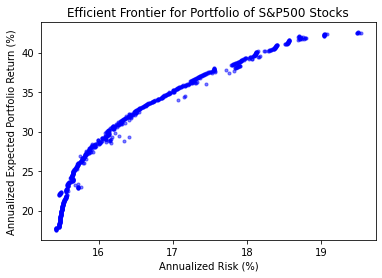

In [26]:
bounds = [minExpectedReturn, maxExpectedReturn]
risk, ret, weights = MeanVarPort(bounds, returns_train)

plt.title('Efficient Frontier for Portfolio of S&P500 Stocks')
plt.xlabel('Annualized Risk (%)')
plt.ylabel('Annualized Expected Portfolio Return (%)' )
plt.scatter(risk, ret, s = np.pi*3, c= "blue" , alpha = 0.5)
plt.show()